# MineB4USign: Mining Legal Documents/Terms and Conditions for Intent


## Content

- [Motivation](#Motivation)
- [End to End Picture: The Pipe Line](#End-to-End-Picture:-The-Pipe-Line)
- [Data collection and processing](#Data-collection-and-processing)
- [Feeling the Data](#Feeling-the-Data)
- [Preprocessing](#Preprocessing)
- [Machine Learning Algorithms](#Machine-Learning-Algorithms)
    - [SVM](#SVM)
    - [Reasons For Selecting SVM](#Reasons-For-Selecting-SVM)

- [Pittfalls and how to avoid them](#Pittfalls-and-how-to-avoid-them)
- [Installing the library](#Installing-the-library)
- [Code walkthrough](#Code-walkthrough)
- [Colorful examples](#Colorful-examples)
- [Data preparation](#Data-preparation)
- [Goal](#Goal)
- [Understanding the data](#Understanding-the-data)
- [SQL to the rescue](#SQL-to-the-rescue)
- [SQL + Plotly + Bar Graph + Python](#SQL-+-Plotly-+-Bar-Graph-+-Python)
- [Further resources](#Further-resources)
- [References and Citations](#References-and-Citations)

## Motivation

How many times have we accepted the terms and conditions while signing up for a service like the google photos etc ? Not a very prudent thing to do right ? We dont blame you. Since all of us use a vast number of such "free" services, its not practical to read through all of the conditions. It is very time consuming (As CMU students thats the last thing we have in plenty !!!). But that does not mean we should not be well informed of what we are signing up for right ?

If only there were a way to get a better understanding of such legal documents without having to read the entire thing. For example, get a general overview of what the document. Get what categories does the document talk about. Ror example ['Data Retention', 'Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences', 'Other', 'Policy Change', 'Third Party Sharing/Collection','User Access, Edit and Deletion', 'User Choice/Control']. 

Once we get this, wouldn't it be great if we can pick and choose to read only thoe parts of the document that addresses a subset of these categories that are important to me. For example, I may be only interested to read those parts of the text that speak about sharing my data with a third party. I dont want to read the entire thing, just the parts that address this particular topic.

Once all this is done, it paves the way for interesting things like Question and Answering system, intent based text summarization (not just ones based on the bi-grams and tri-grams).

This is what we aim to address in this project.



## End to End Picture: The Pipe Line

Any actual ML implementation has a lot more to it than just implementing a ML algorithm. A typical pipeline includes:-
- __Data collection and processing__: 
A large part of ML is actually collecting the data. This may seem trivial but in reality is the most important part of the piple line. Research has shown that many of the ML problems can be solved with relatively simpler techniques as long as there is enough good data.
       
- __Statistical modeling: Getting a feel of the data__:
It is important to understand the data before we try to using ML to find some patterns in it. To quote Zico, it is highly likely that unless we are manually able to see a pattern, the ML model will. 
        
- __Advanced ML techniques__: 
Here comes the actual implementation of the ML algorithm whic is the core of the pipeline.

- __Data visualization__:
All things done so far may not be sufficient to depict the big picture to the end customer who are indifferent to Machine Learning and only care about whether their time is worth what you want to show them. Visualization can be a great tool to convince someone. As they say, a picture is worth a thousand words.


In this project, we have extensively covered the entire pipeline to give an end to end perspective of how Machine Learning can be used to solve a problem.

## Data collection and processing

Here, we are colleting and processing the OPP-115 Corpus. A substantially large amount of work had to be done to bring the data to a format which can be fed to a Machine Learning model.

- __OPP-115__:
For a very long time, there was no labeled data available for analysis of terms and conditions. Enters the OPP-155 data set. This can be used to study the general patterns followed by companies that ask people to accepts their terms and conditions.
In its pure form the data is noisy and as such is useless to an ML model. But once it is cleaned and framed, its pure gold. 
- __Usage__:
Using this data, we are training a model that helps us answer questions we raised in our "motivations" subheading. 
For example-
    - Segmenting the entire document and trying to categorize the segments as to what they tell us about each of the categories ( 'Data Retention', 'Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences', 'Other', 'Policy Change', 'Third Party Sharing/Collection','User Access, Edit and Deletion', 'User Choice/Control')
    
  


In [10]:
import pandas as pd
import numpy as np
import json
import os
import re
from bs4 import BeautifulSoup

In [11]:
def extract_sentences(data, segment, isprint = False):
    """
    parse Json to get unspecified field count
    
    Args:
        data (string): String of properly formatted JSON.

    Returns:
        
    """
    def allindices(string, sub, offset=0):
        listindex = []
        i = string.find(sub, offset)
        while i >= 0:
            listindex.append(i)
            i = string.find(sub, i + 1)
        return listindex
#     print("Segment:", segment)
    soup = BeautifulSoup()
    left_fullstop = -10000
    left_break_tag = -10000
    right_fullstop = 10000
    right_break_tag = 10000

    dictionary_subcategories = {}
    collated_sentences = []
    json_data = json.loads(data)
    for attribute, value in json_data.items():
#         print("attribute:", attribute)
        endIndexInSegment = value["endIndexInSegment"]-1
        if isprint:
            print("endIndexInSegment:", endIndexInSegment)
        startIndexInSegment = value["startIndexInSegment"]
        if isprint:
            print("startIndexInSegment:", startIndexInSegment)

        json_value = value["value"]
        if json_value == "Unspecified":
            continue
        else:
            if startIndexInSegment == 0 and endIndexInSegment == len(segment):
                collated_sentences.append(segment[startIndexInSegment:endIndexInSegment-1].strip())
                continue
            if startIndexInSegment == 0:
                left_fullstop = 0
                left_break_tag = 0
            if endIndexInSegment == len(segment):
                right_fullstop = 0
                right_break_tag = 0
            
            
#             print("value: ", value)
            full_stops = allindices(segment, ".")
            break_tags = allindices(segment, "<br>")
            if isprint:
                print("full_stops: ", full_stops)
            if isprint:
                print("break_tags: ", break_tags)
            left_fullstops = [x for x in full_stops if x <= startIndexInSegment]
            right_fullstops = [x for x in full_stops if x >= endIndexInSegment]
            left_break_tags = [x for x in break_tags if x <= startIndexInSegment]
            right_break_tags = [x for x in break_tags if x >= endIndexInSegment]
            
            if len(left_fullstops) > 1: 
                if left_fullstop is not 0:
                    left_fullstop = max(left_fullstops)+1
            else:
                if len(left_fullstops) == 1:
                    if left_fullstop is not 0:
                        left_fullstop = left_fullstops[0]+1

            if len(right_fullstops) > 1: 
                if right_fullstops is not 0:
                    right_fullstop = min(right_fullstops)+1
            else:
                if len(right_fullstops) == 1:
                    if right_fullstop is not 0:
                        right_fullstop = right_fullstops[0]+1
                        
            if len(left_break_tags) > 1: 
                if left_break_tag is not 0:
                    left_break_tag = max(left_break_tags)+4
            else:
                if len(left_break_tags) == 1:
                    if left_break_tag is not 0:
                        left_break_tag = left_break_tags[0]+4

            if len(right_break_tags) > 1: 
                if right_break_tag is not 0:
                    right_break_tag = min(right_break_tags)+4
            else:
                if len(right_break_tags) == 1:
                    if right_break_tag is not 0:
                        right_break_tag = right_break_tags[0]+4

            if isprint:
                print("right_fullstop: ", right_fullstop)
            if isprint:
                print("right_break_tag: ", right_break_tag)
            left = max(left_fullstop, left_break_tag)
            right = min(right_fullstop, right_break_tag)
            if isprint:
                print("Collated segment:", segment[left:right].strip())
            sentence = segment[left:right].strip()
            cleantext = BeautifulSoup(sentence, "lxml").text
            if cleantext not in collated_sentences:
                collated_sentences.append(cleantext)
            else:
                continue
            dictionary_subcategories[attribute] = cleantext
#     print("dictionary_subcategories: ", dictionary_subcategories)
    return collated_sentences, dictionary_subcategories

In [12]:
def create_df(path_sanitized_policies = "OPP-115/sanitized_policies/" , path_annotations = "OPP-115/consolidation/threshold-1.0-overlap-similarity/"):
    """
    parse Json to get unspecified field count
    
    Args:
        data (string): String of properly formatted JSON.

    Returns:
        
    """
    def find(S, T):
        return [match.start() for match in re.finditer(re.escape(S), T)]

    dictionary = {}
#     path_sanitized_policies = "OPP-115/sanitized_policies/"
#     path_annotations = "OPP-115/consolidation/threshold-1.0-overlap-similarity/"
    regex_html = "(.*).html"
    regex_csv = "(.*).csv"
    for filename_sanitized_policies in os.listdir(path_sanitized_policies):
        if filename_sanitized_policies == ".DS_Store":
            continue
#         print("filename_sanitized_policies: ", filename_sanitized_policies)
        m = re.match(regex_html, filename_sanitized_policies)
        groups = m.groups()
        filename_sanitized_policies_no_extension = groups[0]
#         print("filename: ", filename_sanitized_policies)
        path_sanitized_policies_file = path_sanitized_policies + "/" + filename_sanitized_policies 
#         file_list = os.listdir(path_annotations)
        f = open(path_sanitized_policies_file, "r")
        content = f.read()
#         print(content)
        
        temp_positions = find("|||", content)
#         print("temp_positions: ", temp_positions)        
        a = 0
        all_positions = [a] + temp_positions
#         print("all_positions: ", len(all_positions))
        all_positions_end = temp_positions + [len(content)]
#         print("all_positions_end: ", len(all_positions_end))
        
        segments = content.split("|||")
        path_annotations_file = path_annotations + filename_sanitized_policies_no_extension + ".csv"
#         print("path_annotations_file: ", path_annotations_file)
        annotations = pd.read_csv(path_annotations_file, keep_default_na = False, names = ["annotation ID", "batch ID", "annotator ID", "policy ID", "segment ID", "category name", "attribute-value", "policy URL", "date"]) 
        annotations = pd.concat([annotations, pd.get_dummies(annotations['category name'])], axis=1)
#         adding the segments to the dataframe.
        sLength = len(annotations['annotation ID'])
        annotations['segment'] = pd.Series(np.random.randn(sLength), index=annotations.index)
        annotations['segment'] = annotations['segment'].astype('str')
        
        annotations['collated_sentences'] = pd.Series(np.random.randn(sLength), index=annotations.index)
        annotations['collated_sentences'] = annotations['segment'].astype('str')
        annotations['sub_categories_dictionary'] = pd.Series(np.random.randn(sLength), index=annotations.index)
        annotations['sub_categories_dictionary'] = annotations['sub_categories_dictionary'].astype('object')
        annotations['start'] = [all_positions[i] for i in annotations["segment ID"]]
        annotations['end'] = [all_positions_end[i] for i in annotations["segment ID"]]
#         r = annotations['start']
#         l = annotations['end']
#         for i in range(len(annotations['start'])):
#             print("start: ", r[i])
#             print("end: ", l[i])
        count = 1
        for i, row in annotations.iterrows():
#             segment_id = row['segment ID']
#             annotations.at[i, 'segment'] = segments[segment_id]
            segment_id = row['segment ID']
            cleansegment = BeautifulSoup(segments[segment_id], "html").text
            annotations.at[i, 'segment'] = cleansegment
#             print("annotations.at[i, 'attribute-value']", annotations.at[i, 'attribute-value'])
#             print("segments[segment_id]: ", segments[segment_id])
            count +=1
            istrue = False
#             if count == 8:
#                 istrue = True
            collated_sentences, dictionary_subcategories = extract_sentences(annotations.at[i, 'attribute-value'], segments[segment_id], istrue)
#             if count == 8:
#                 print("segments[segment_id]:", segments[segment_id])
#                 print("collated_sentences: ", collated_sentences)
            annotations.at[i, 'collated_sentences'] = collated_sentences
            annotations.at[i, 'sub_categories_dictionary'] = dictionary_subcategories
            
        dictionary[filename_sanitized_policies_no_extension] = annotations
    return dictionary
        

## Feeling the Data

Here we manually analyse and understand the data. This is essential gauge what sort of Machine Learning algorithm we can implement on top of this data.



In [13]:
annotations = create_df()

/Users/bhramoss/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/bhramoss/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [15]:
annotations['1582_msn.com'].head()

,annotation ID,batch ID,annotator ID,policy ID,segment ID,category name,attribute-value,policy URL,date,Data Retention,...,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control,segment,collated_sentences,sub_categories_dictionary,start,end
0,C214,test_category_labeling_highlight_fordham_cccc,117,3789,0,Other,"{""Other Type"": {""endIndexInSegment"": 24, ""star...",3/1/15,http://www.microsoft.com/privacystatement/en-u...,0,...,1,0,0,0,0,Last Updated: March 2015,[Last Updated: March 2015 ],{'Other Type': 'Last Updated: March 2015 '},0,34
1,11310,test_category_labeling_highlight_fordham_bbbb,116,3789,0,Policy Change,"{""Change Type"": {""endIndexInSegment"": 24, ""sta...",3/1/15,http://www.microsoft.com/privacystatement/en-u...,0,...,0,1,0,0,0,Last Updated: March 2015,[Last Updated: March 2015 ],{'Notification Type': 'Last Updated: March 201...,0,34
2,C215,test_category_labeling_highlight_fordham_bbbb,116,3789,1,Other,"{""Other Type"": {""endIndexInSegment"": 310, ""sta...",3/1/15,http://www.microsoft.com/privacystatement/en-u...,0,...,1,0,0,0,0,Bing and MSN Privacy Statement This privac...,[This privacy statement applies to Bing and MS...,{'Other Type': 'This privacy statement applies...,34,357
3,11312,test_category_labeling_highlight_fordham_bbbb,116,3789,2,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",3/1/15,http://www.microsoft.com/privacystatement/en-u...,0,...,0,0,0,0,0,Cookies & Similar Technologies When you us...,"[ Cookies & Similar Technologies , When you u...",{'Collection Mode': ' Cookies & Similar Techno...,357,989
4,11313,test_category_labeling_highlight_fordham_bbbb,116,3789,2,First Party Collection/Use,"{""Collection Mode"": {""endIndexInSegment"": -1, ...",3/1/15,http://www.microsoft.com/privacystatement/en-u...,0,...,0,0,0,0,0,Cookies & Similar Technologies When you us...,"[ Cookies & Similar Technologies , For exampl...",{'Collection Mode': ' Cookies & Similar Techno...,357,989


## Preprocessing

Once we analyse the data manually, we can see if any further changes need to be made in order to feed it to an ML algorithm that we are contemplating about. 

In [16]:
# This code cleans the sentence and does preprocessing
# Source: https://gist.github.com/ameyavilankar/10347201
import string
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
import re
"""
Preprocess a list of sentences
    
Args:
    sentences (list): A list of sentences to be preprocessed
Returns:
    Preprocessed sentence
"""

stop_words = set(stopwords.words('english'))

def preprocess(list_sentence):
    sentence = ''.join(list_sentence)
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    filtered_words = filter(lambda token: token not in stop_words, tokens)
    processed_sentence = " ".join(filtered_words)
    return processed_sentence

sentence = """We also use the information we collect to maintain and improve the quality,
security and integrity of our services. For example we may use this information
for research purposes and to improve the relevancy of Bing search results. 
This information is also necessary in order to detect and protect against 
security threats such as botnet attacks, click fraud, worms, and other threats. 
For Microsoft Services that are powered by Bing, we may also use this information 
to personalize your experience. Please see the Microsoft Services Powered by Bing 
section for more information."""
print("Original Text \n")
print(sentence)
print(" ")
print("Processed Text \n")
print(preprocess(sentence))

Original Text 

We also use the information we collect to maintain and improve the quality,
security and integrity of our services. For example we may use this information
for research purposes and to improve the relevancy of Bing search results. 
This information is also necessary in order to detect and protect against 
security threats such as botnet attacks, click fraud, worms, and other threats. 
For Microsoft Services that are powered by Bing, we may also use this information 
to personalize your experience. Please see the Microsoft Services Powered by Bing 
section for more information.
 
Processed Text 

also use information collect maintain improve quality security integrity service example may use information research purpose improve relevancy bing search result information also necessary order detect protect security threat botnet attack click fraud worm threat microsoft service powered bing may also use information personalize experience please see microsoft service powered 

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
import math
from collections import Counter

In [18]:
#Preparing categories and sub-categories into a list and dictionary respectively
categories = ['Data Retention', 'Data Security', 'Do Not Track', 'First Party Collection/Use', 'International and Specific Audiences', 'Other', 'Policy Change', 'Third Party Sharing/Collection','User Access, Edit and Deletion', 'User Choice/Control']
sub_categories = {}
sub_categories['First Party Collection/Use']=['Does/Does Not','Collection Mode','Action First-Party','Identifiability','Personal Information Type','Purpose','User Type','Choice Type','Choice Scope']
sub_categories['Third Party Sharing/Collection']=['Third Party Entity','Does/Does Not','Action Third Party','Identifiability','Personal Information Type','Purpose','User Type','Choice Type','Choice Scope']
sub_categories['User Choice/Control']=['Choice Type','Choice Scope','Personal Information Type','Purpose','User Type']
sub_categories['User Access, Edit and Deletion']=['Access Type''Access Scope','User Type']
sub_categories['Data Retention']=['Retention Period','Retention Purpose','Personal Information Type']
sub_categories['Data Security']=['Security Measure']
sub_categories['Policy Change']=['Change Type','Notification Type','User Choice']
sub_categories['Do Not Track']=['Do Not Track policy']
sub_categories['International and Specific Audiences']=['Audience Type']
sub_categories['Other']=['Other Type']
for cat in categories:
    print("Category:",cat,"\n","sub_categories :",sub_categories[cat],"\n")                     

Category: Data Retention 
 sub_categories : ['Retention Period', 'Retention Purpose', 'Personal Information Type'] 

Category: Data Security 
 sub_categories : ['Security Measure'] 

Category: Do Not Track 
 sub_categories : ['Do Not Track policy'] 

Category: First Party Collection/Use 
 sub_categories : ['Does/Does Not', 'Collection Mode', 'Action First-Party', 'Identifiability', 'Personal Information Type', 'Purpose', 'User Type', 'Choice Type', 'Choice Scope'] 

Category: International and Specific Audiences 
 sub_categories : ['Audience Type'] 

Category: Other 
 sub_categories : ['Other Type'] 

Category: Policy Change 
 sub_categories : ['Change Type', 'Notification Type', 'User Choice'] 

Category: Third Party Sharing/Collection 
 sub_categories : ['Third Party Entity', 'Does/Does Not', 'Action Third Party', 'Identifiability', 'Personal Information Type', 'Purpose', 'User Type', 'Choice Type', 'Choice Scope'] 

Category: User Access, Edit and Deletion 
 sub_categories : ['Acces

In [19]:
# This code combines all dataframes and cleans the respective text values, finally returns a dataframe
"""
Combine all dataframes for 115 Privacy Policies into a dataframe
and process segments, paragraphs.
    
Args:
    annotations (dict) : A dictionary of annotations where text from a privacy
    policy is and collatted in a dataframe.
Returns:
    all_df (dataframe) : Combined dataframe
"""
def collate_all_categories(annotations):
    all_df = pd.DataFrame()
    for key, val in annotations.items():
        cat_df = pd.DataFrame()
        cat_df = annotations[key].drop(['sub_categories_dictionary'], axis=1)
        all_df = all_df.append(cat_df)
    all_df['collated_sentences'] = [preprocess(list_s) for list_s in all_df['collated_sentences']]
    all_df = all_df.fillna(value=0.0)
    return all_df
all_df_categories = collate_all_categories(annotations)

In [20]:
import matplotlib
matplotlib.use("svg")
# AUTOLAB_IGNORE_START
%matplotlib inline
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
plt.style.use("ggplot")
def plot_tfidf_classfeats_h(dfs):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    color = ['r', 'g']
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color=color[i])
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

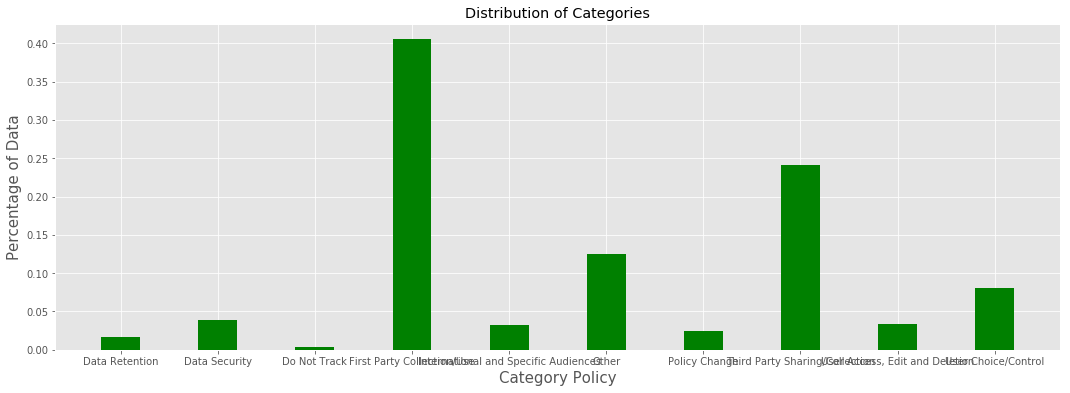

In [21]:
# TODO: Make this plot better
"""
Combine all dataframes for 115 Privacy Policies into a dataframe
and process segments, paragraphs.
    
Args:
    annotations (dict) : A dictionary of annotations where text from a privacy
    policy is and collatted in a dataframe.
Returns:
    all_df (dataframe) : Combined dataframe
"""
def plot_categories(annotations):
    total_count = len(all_df_categories)
    cat_count = {}
    cat_weight = {}
    for cat in categories:
        cat_dict = Counter(all_df_categories[cat])
        cat_count[cat] = cat_dict[1.0]/total_count
        cat_weight[cat] = (math.ceil(total_count/cat_dict[0.0]), math.ceil(total_count/cat_dict[1.0]))
    plt.figure(figsize=(18,6))
    plt.bar(cat_count.keys(), cat_count.values(), color='g', width=0.4)
    plt.xlabel('Category Policy', fontsize=15)
    plt.ylabel('Percentage of Data', fontsize=15)
    plt.title('Distribution of Categories')
    plt.show()
plot_categories(annotations)

In [22]:
all_df_categories
pd.options.display.max_columns = None
display(all_df_categories.head())


,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control,annotation ID,annotator ID,attribute-value,batch ID,category name,collated_sentences,date,end,policy ID,policy URL,segment,segment ID,start
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15956,116,"{""Other Type"": {""selectedText"": ""Welcome to th...",test_category_labeling_highlight_fordham_bbbbb,Other,welcome google privacy policy use google servi...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,18039,117,"{""Other Type"": {""selectedText"": ""When you use ...",test_category_labeling_highlight_fordham_ccccc,Other,use google service trust u information privacy...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,16704,118,"{""Other Type"": {""selectedText"": ""When you use ...",test_category_labeling_highlight_fordham_ddddd,Other,use google service trust u information privacy...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16705,118,"{""Choice Type"": {""selectedText"": ""you can find...",test_category_labeling_highlight_fordham_ddddd,User Choice/Control,remember find control manage information prote...,https://www.google.com/intl/en/policies/privacy/,442,3864,6/30/15,Welcome to the Google Privacy Policy When ...,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,15957,116,"{""Change Type"": {""selectedText"": ""Privacy Poli...",test_category_labeling_highlight_fordham_bbbbb,Policy Change,privacy policy last modified june 30 2015 view...,https://www.google.com/intl/en/policies/privacy/,534,3864,6/30/15,"Privacy Policy Last modified: June 30, 2015 ...",1,442


### Finally, all the preprocessing (almost) is done. Now we can finally move forward.

## Machine Learning Algorithms

After analysing the data that we are working with, we realized that SVM would be one of the better options.

### SVM
In machine learning, support vector machines (SVMs, also support vector networks[1]) are supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis. Given a set of training examples, each marked as belonging to one or the other of two categories, an SVM training algorithm builds a model that assigns new examples to one category or the other, making it a non-probabilistic binary linear classifier (although methods such as Platt scaling exist to use SVM in a probabilistic classification setting). An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall. (Source: Wikipedia)

### Reasons For Selecting SVM 
- SVMs has the ability to learn independent of the dimensionality of the feature space.
- Since the maximum margin is drawn based only on the support vectors and not the number of features, it can generalize even in the presence of very many features
- SVM is very robust, eliminating the need for expensive parameter tuning which plagues other methods.
- Text categorize problems are linearly separable which fits into the behaviour of SVM. 
- SVM is good for cases where there is sparse data. Since the document vectors are sparse, SVM will perform well on it.


In [23]:
#source: https://buhrmann.github.io/tfidf-analysis.html
"""
Analyse Confusion Matrix
    
Args: 
    confusion_matrix (numpy matrix) : Confusion Matrix
Returns:
    measures (dict) : A dictionary of scores on various metrics
"""
def analyse_confusion_matrix(conf_mat):
    tp, fp, fn, tn = conf_mat.flatten()
    measures = {}
    measures['accuracy'] = (tp + tn) / (tp + fp + fn + tn)
    measures['specificity'] = tn / (tn + fp)        
    measures['sensitivity'] = tp / (tp + fn)    
    measures['precision'] = tp / (tp + fp)
    measures['f1score'] = 2*tp / (2*tp + fp + fn)
    return measures

In [24]:
def evaluate(y_pred, y_test):
    """ Evaluates classifier predictions
        Inputs:
            y_pred (array_like): output from classifier
            y_test (array_like): true class label
        Output:
            (double): accuracy rate as defined above
    """
    len_range=len(y_test)
    count = float(np.sum(y_pred==y_test))
    accuracy = (count)/len_range
    return accuracy
    pass

In [26]:
"""
Build Category Models
    
Args: 
    confusion_matrix (numpy matrix) : Confusion Matrix
Returns:
    measures (dict) : A dictionary of scores on various metrics
"""
def build_category_models(categories_list, cross_validate = True):
    vectorizer_dict = {}
    model_dict = {}
    false_pos = {}
    false_neg = {}
    cat_corpus = {}
    cat_TFIDF = {}
    cat_labels = {}
    cat_accuracy = {}
    cat_confusion_matrix_dict = {}
    cat_score_dict = {}
    
    
    for cat in categories_list:
#         print("Working on Category :",cat)
        exp_df = pd.DataFrame()
        exp_df[cat]=all_df_categories[cat]
        exp_df['segment ID']=all_df_categories['segment ID']
        exp_df['collated_sentences']=all_df_categories['collated_sentences']
        exp_df = exp_df.drop_duplicates(subset=['segment ID',cat,'collated_sentences'], keep='first')

        corpus = exp_df['collated_sentences'].values
        labels = exp_df[cat].reset_index(drop=True)
#         print("Total Length of Corpus, Labels :",len(labels))
        
        totalsvm = 0           
        ConfusionMat = np.zeros((2,2));
        scores_kfold = []
        false_pos[cat] = set()
        false_neg[cat] = set()

        
        if (cross_validate):
        
            kf = StratifiedKFold(n_splits=2, shuffle=True)

            modelSVC = SVC(kernel='linear', class_weight='balanced')
            for train_index, val_index in kf.split(corpus,labels):
                X_train = [corpus[i] for i in train_index]
                X_val = [corpus[i] for i in val_index]
                y_train, y_val = labels[train_index], labels[val_index]

                vectorizer = TfidfVectorizer(ngram_range = (1,3), sublinear_tf=True, use_idf=True, stop_words='english')
                train_corpus_tf_idf = vectorizer.fit_transform(X_train)
                val_corpus_tf_idf = vectorizer.transform(X_val)
                


                modelSVC.fit(train_corpus_tf_idf,y_train)
                resultSVC_labels = np.squeeze(modelSVC.predict(val_corpus_tf_idf))
                scores_kfold.append(evaluate(resultSVC_labels, y_val))

#             print("Scores with cross validation:", scores_kfold)
            ConfusionMat = confusion_matrix(y_val, resultSVC_labels)
            cat_confusion_matrix_dict[cat] = ConfusionMat

            #Collect indices of false positive and negatives
            fp_idx = np.where((resultSVC_labels==1) & (y_val==0))[0]
            fn_idx = np.where((resultSVC_labels==0) & (y_val==1))[0]
            
            
            #Update Category values in dictionary
            false_pos[cat].update(val_index[fp_idx])
            false_neg[cat].update(val_index[fn_idx])
#             cat_accuracy[cat] = scores
            vectorizer_dict[cat]=vectorizer
            model_dict[cat]= modelSVC
            cat_corpus[cat] = corpus[train_index]
            cat_TFIDF[cat] = train_corpus_tf_idf
            cat_labels[cat] = y_train
            cat_score_dict[cat] = analyse_confusion_matrix(ConfusionMat)
#             print("For category :",val)
#             print ("Confusion Matrix :\n",ConfusionMat)
#             print(analyse_confusion_matrix(ConfusionMat))
#             print(" ")
            
            
        else:
#             print("Building Model..")
            vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, ngram_range = (2,3), sublinear_tf=True, use_idf=True, stop_words='english')
            #building TF-IDF Matrix
            X = corpus
            #splitting the dataset
            P = np.random.permutation(X.shape[0])
            test_index = math.floor(0.8*len(P))
            train_indexes=P[0:test_index]
            test_indexes=P[test_index:]
#             print("test_indexes", test_indexes)
            X_train = vectorizer.fit_transform(X[train_indexes])
            X_test = vectorizer.transform(X[test_indexes])
            y_train = labels[train_indexes]
            y_test = labels[test_indexes]
            #train classifier
            clf = SVC(kernel='linear', class_weight='balanced')
#             print("Shape :", X_train.shape, y_train.shape)
            clf.fit(X_train, y_train)
            #predict and evaluate predictions
            predictions = clf.predict(X_test)
            #false positive and negatives
            fp_idx = np.where((predictions==1) & (y_test==0))[0]
            fn_idx = np.where((predictions==0) & (y_test==1))[0]
            #Update Category values in dictionary
            false_pos[cat].update(test_indexes[fp_idx])
            false_neg[cat].update(test_indexes[fn_idx])
            
            vectorizer_dict[cat]=vectorizer
            model_dict[cat]=clf
            cat_corpus[cat] = corpus[train_indexes]
            cat_TFIDF[cat] = X_train
            cat_labels[cat] = y_train
        
            ConfusionMat = confusion_matrix(y_test, predictions)
            cat_confusion_matrix_dict[cat] = ConfusionMat
#             print("For category :",cat)
#             print ("Confusion Matrix :\n",ConfusionMat)
#             print(analyse_confusion_matrix(ConfusionMat))
#             print(" ")
            cat_score_dict[cat] = analyse_confusion_matrix(ConfusionMat)
#             print("Done.")
            
            
    return(model_dict, vectorizer_dict, false_pos, false_neg, cat_corpus, cat_TFIDF, cat_labels, cat_confusion_matrix_dict, cat_score_dict)
model_dict, vectorizer_dict, false_pos, false_neg, cat_corpus, cat_TFIDF, cat_labels, cat_confusion_matrix_dict, cat_score_dict = build_category_models(categories, False)

## Confusion Matrix

In the field of machine learning and specifically the problem of statistical classification, a confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix). Each row of the matrix represents the instances in a predicted class while each column represents the instances in an actual class (or vice versa). The name stems from the fact that it makes it easy to see if the system is confusing two classes (i.e. commonly mislabeling one as another). [__Source- Wikipedia__]

Analysis of Categories : Data Retention


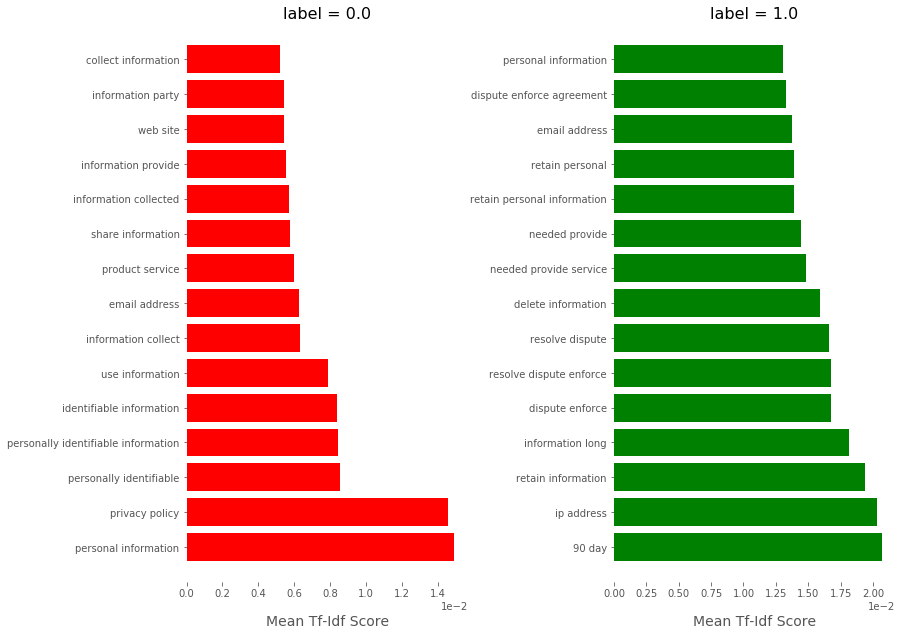

Analysis of Categories : Data Security


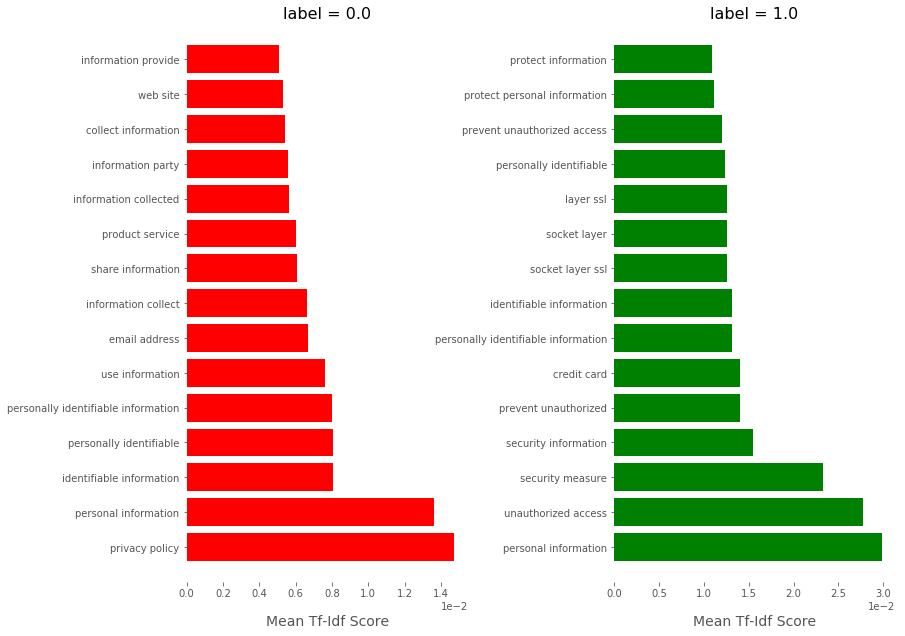

Analysis of Categories : Do Not Track


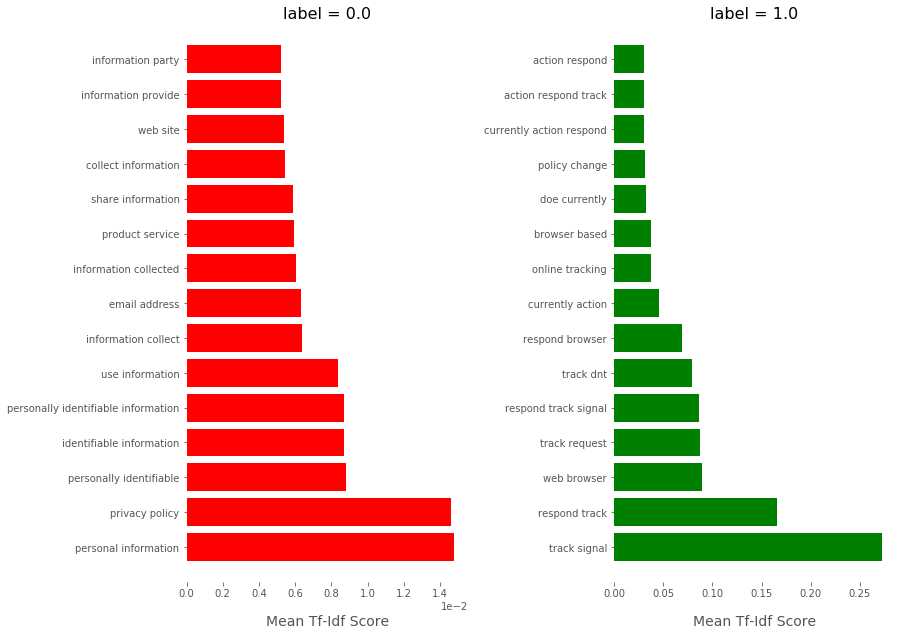

Analysis of Categories : First Party Collection/Use


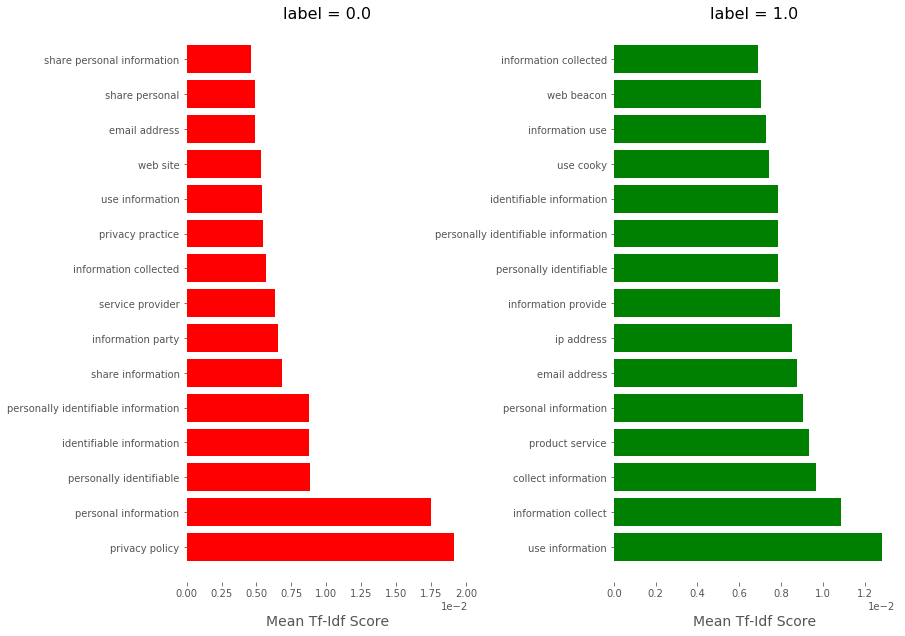

Analysis of Categories : International and Specific Audiences


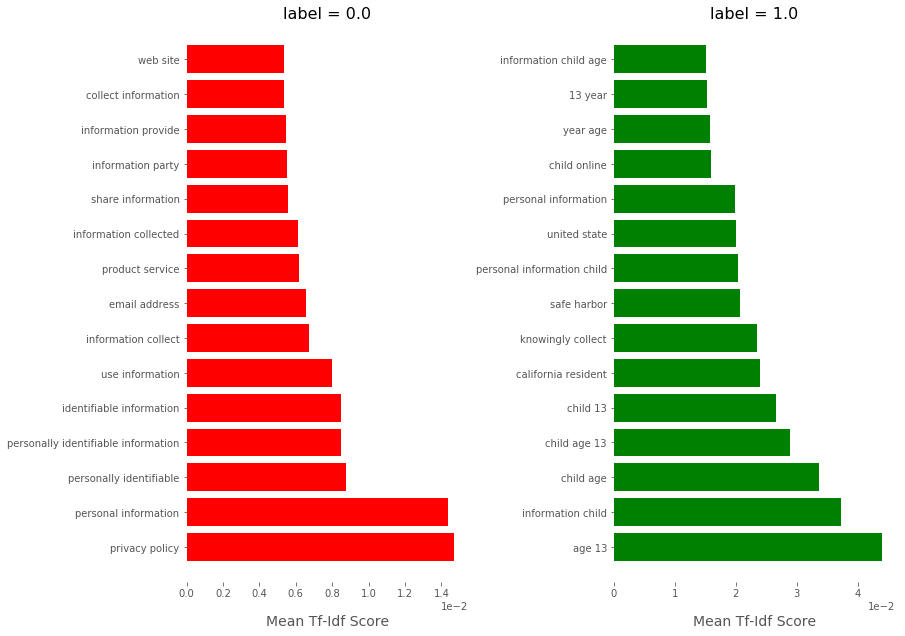

Analysis of Categories : Other


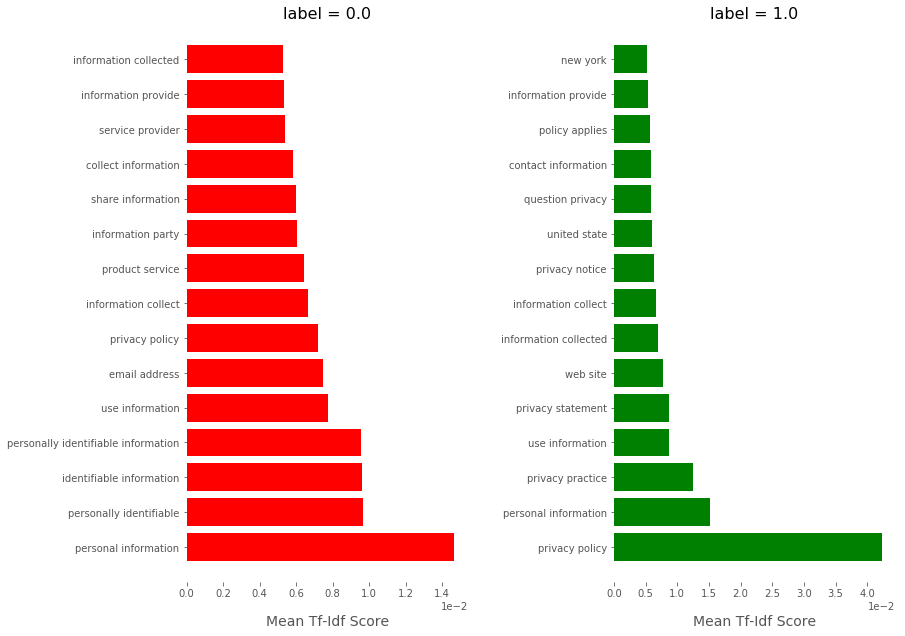

Analysis of Categories : Policy Change


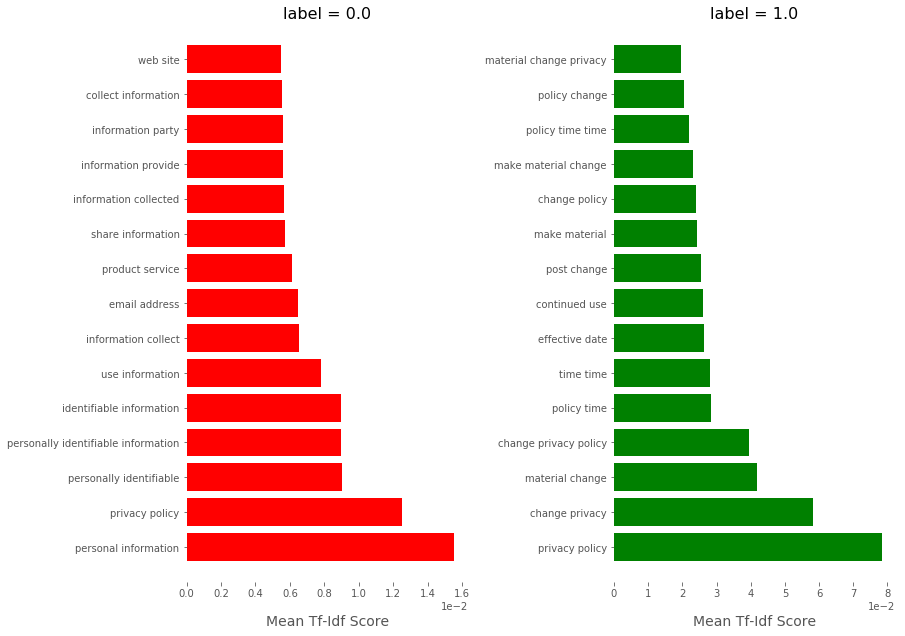

Analysis of Categories : Third Party Sharing/Collection


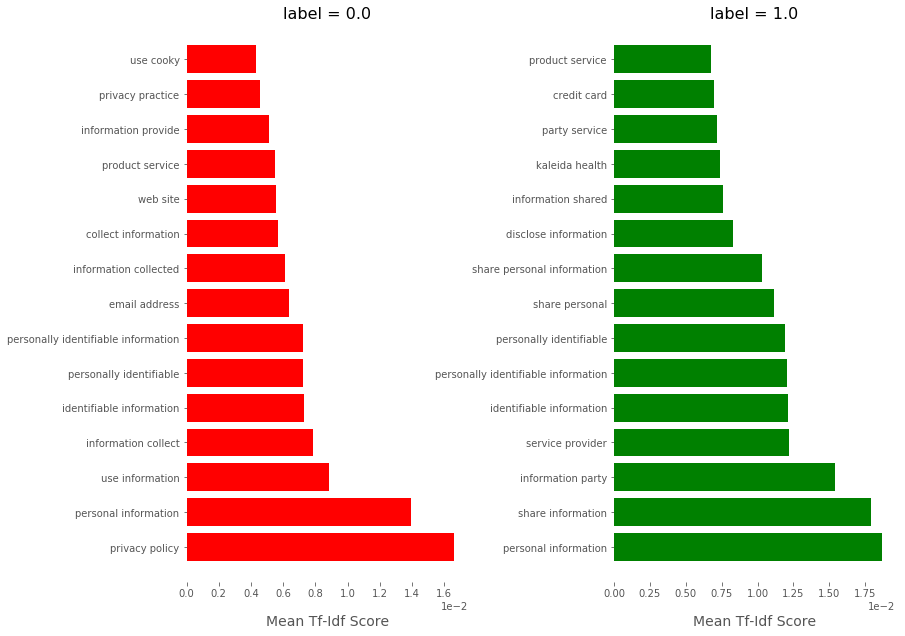

Analysis of Categories : User Access, Edit and Deletion


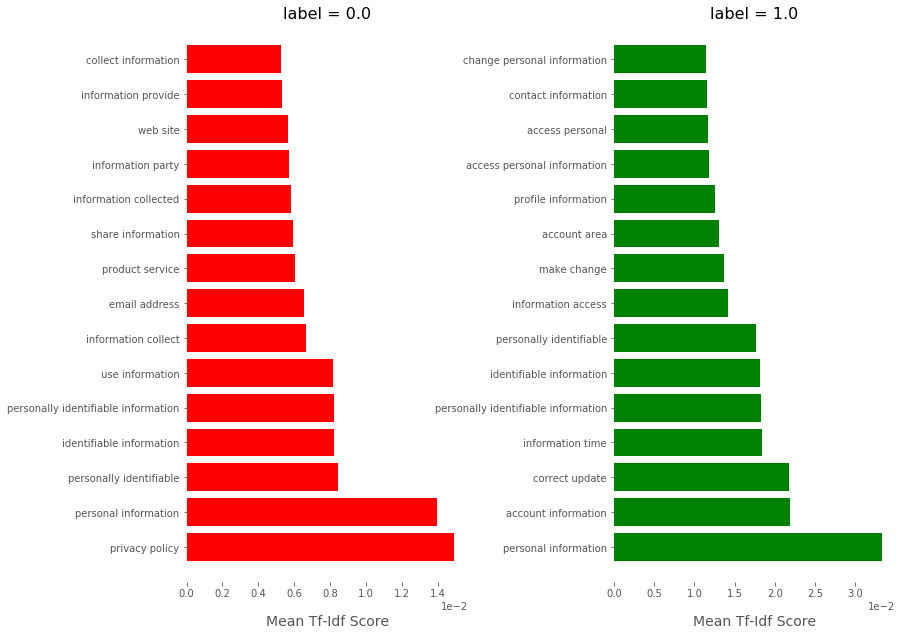

Analysis of Categories : User Choice/Control


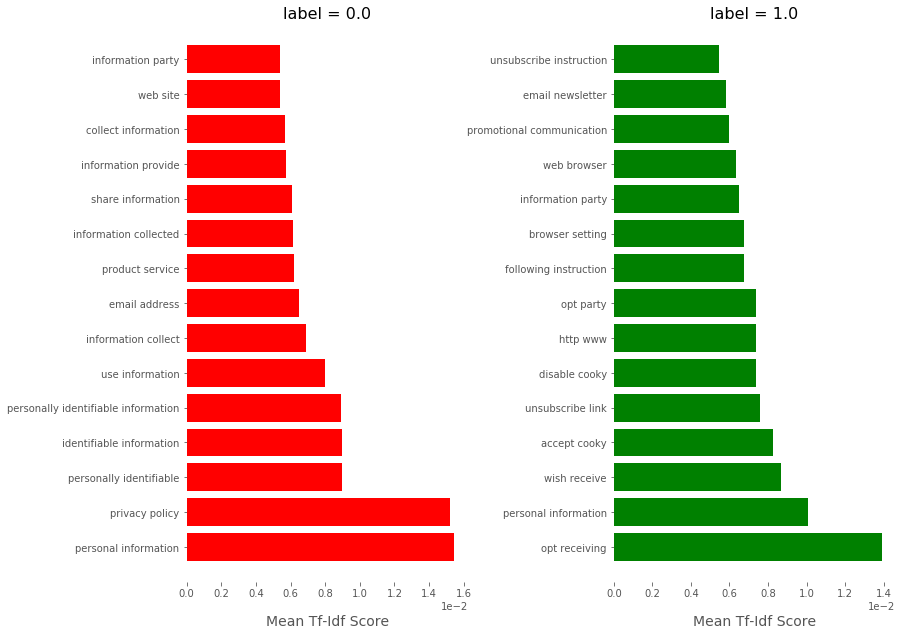

In [27]:
"""
Analysis of TFIDF Features 
    
Args: 
    confusion_matrix (numpy matrix) : Confusion Matrix
Returns:
    measures (dict) : A dictionary of scores on various metrics
"""
features = {}
for cat in categories:
    features[cat] = vectorizer_dict[cat].get_feature_names()

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

for cat in categories:
    dfs = top_feats_by_class(cat_TFIDF[cat], cat_labels[cat], features[cat], min_tfidf=0.1, top_n=15)
    print("Analysis of Categories :", cat)
    plot_tfidf_classfeats_h(dfs)


In [28]:
"""
collate_all_sub_categories

Args: 
    confusion_matrix (numpy matrix) : Confusion Matrix
Returns:
    measures (dict) : A dictionary of scores on various metrics
"""
def collate_all_sub_categories(annotations):
    all_df_category = {}
    
    # Create dataframe by combining values from all files
    all_df = pd.DataFrame()
    for key, val in annotations.items():
        sub_cat_df = pd.DataFrame()
        sub_cat_df = annotations[key].drop(['collated_sentences'], axis=1)
        all_df = all_df.append(sub_cat_df)
    all_df_sub_cats = all_df.fillna(value=0.0)
    all_df_sub_cats=all_df_sub_cats.reset_index()
    for index, row in all_df_sub_cats.iterrows():
        cat = row['category name']
        sub_cat_keys = list(row['sub_categories_dictionary'].keys())
        for sub_cat in sub_categories[cat]:
            if (sub_cat in sub_cat_keys):
                all_df_sub_cats.loc[index, sub_cat]=preprocess(row['sub_categories_dictionary'][sub_cat])
                all_df_sub_cats.loc[index, sub_cat+'_label']=1
            else:
                all_df_sub_cats.loc[index, sub_cat]=preprocess(row['segment'])
                all_df_sub_cats.loc[index, sub_cat+'_label']=0
    
    return all_df_sub_cats
all_df_sub_cats = collate_all_sub_categories(annotations)
print("Sub Category DataFrame Built.. ")
print("Dataframe is of length ", len(all_df_sub_cats))

Sub Category DataFrame Built.. 
Dataframe is of length  20145


In [29]:
"""
Build Models for Sub Categories at Sentence Level granularity 
    
Args: 
    confusion_matrix (numpy matrix) : Confusion Matrix
Returns:
    measures (dict) : A dictionary of scores on various metrics
"""
def build_sub_categories_models(all_df_sub_categories):
    model_dict = {}
    vectorizer_dict = {}
    for cat in categories:
#         print("Working on Category :",cat)
        cat_df = all_df_sub_categories
        for sub_cat in sub_categories[cat]:
#             print("Working on Sub-Category :",sub_cat)
            new_df = pd.DataFrame()
            new_df[sub_cat]=cat_df[sub_cat]
            new_df['segment ID']=cat_df['segment ID']
            new_df['labels'] = cat_df[sub_cat+'_label']
            new_df = new_df.drop_duplicates(subset=['segment ID',sub_cat], keep='first')
            new_df = new_df.dropna(axis=0, how='any')
            corpus = new_df[sub_cat].values
            labels = new_df['labels'].reset_index(drop=True)
#             print("Total Length of Corpus, Labels :",len(labels))
            zero_samples = Counter(labels)[0.0]
            one_samples = Counter(labels)[1.0]
#             print("zero samples:", zero_samples)
            if(not zero_samples or not one_samples):
#                 print("Only one category label present")
                break
            totalsvm = 0           
            ConfMatrix = np.zeros((2,2));  
            
            vectorizer = TfidfVectorizer(min_df=5, max_df = 0.8, ngram_range = (1,3), sublinear_tf=True, use_idf=True, stop_words='english')
            X = corpus
            P = np.random.permutation(X.shape[0])
            test_index = math.floor(0.8*len(P))
            train_indexes=P[0:test_index]
            test_indexes=P[test_index:]
            X_train = vectorizer.fit_transform(corpus[train_indexes])
            X_test = vectorizer.transform(corpus[test_indexes])
            y_train = labels[train_indexes]
            y_test = labels[test_indexes]
            clf = SVC(kernel='linear', class_weight='balanced')
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_test)
        
            model_dict[sub_cat]=clf
            vectorizer_dict[sub_cat]=vectorizer
    
    return(model_dict, vectorizer_dict)
sub_category_model, sub_category_vectorizer=build_sub_categories_models(all_df_sub_cats)

In [58]:
def end_to_end(categories, model_dict, vectorizer_dict, sub_category_model, sub_category_vectorizer):
    path_sanitized_policies = "OPP-115/sanitized_policy_test/"
    path_annotations = "OPP-115/consolidation_test/"
    test_df = create_df(path_sanitized_policies, path_annotations)
    test_df_dict = {}
    for k, v in test_df.items():
        temp = pd.DataFrame()
        temp["segment ID"] = v["segment ID"]
        temp["segment"] = v["segment"]
        temp["category name"] = v["category name"]
        temp["start"] = v["start"]
        temp["end"] = v["end"]
       
        temp = temp.drop_duplicates(subset=['segment ID'], keep='first')
        temp["segment"] = [preprocess(list_s) for list_s in temp["segment"]]
#             temp["analysis"] = pd.Series(np.random.randn(len(temp)), index=temp.index)
        temp["analysis"] = ''
        corpus_temp = temp["segment"].values
        
        for category in categories:
#             print("Classifying For category:", category)
            vectorizer = vectorizer_dict[category]
            X_vect = vectorizer.transform(corpus_temp)
            temp[category] = model_dict[category].predict(X_vect)
            indexes = temp.index[temp[category] == 1.0].tolist()
#             print("sub_Categories",sub_categories[category])
#             print("Category: ", category)
            if (indexes):
#                 print("indexes :", indexes)
                if category == "International and Specific Audiences":
#                     print("Entering: ", indexes)
#                     temp.analysis.iloc[indexes] = "test"
                    for idx in indexes:
                        temp.loc[idx, "analysis"]+=" "+ "Audience Type"
                    continue
                to_predict = [temp.loc[idx, 'segment'] for idx in indexes]
                for sub_cat in sub_categories[category]:
                    try:
                        sub_cat_model=sub_category_model[sub_cat]
                    except:
                        break
#                     print("sub_cat",sub_cat, sub_cat_model)
                    if (sub_cat_model):
                        predictions = sub_cat_model.predict(sub_category_vectorizer[sub_cat].transform(to_predict))
#                         if category is "International and Specific Audiences":
#                         print("T-->",category," ----", type(category))
#                         print("predictions", predictions)
                        for idx in indexes:
                            i=0
                            if (predictions[i]==1.0):
#                                 print()
                                temp.loc[idx, "analysis"]+=" "+sub_cat
                            i+=1            
#             print(temp)
#             print("Classification For category Done!")
        test_df_dict[k] = temp
    return test_df_dict
ti = end_to_end(['First Party Collection/Use', 'International and Specific Audiences'], model_dict, vectorizer_dict, sub_category_model, sub_category_vectorizer)

/Users/bhramoss/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/bhramoss/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [59]:
ti['1683_dailynews.com']

,segment ID,segment,category name,start,end,analysis,First Party Collection/Use,International and Specific Audiences
0,0,privacy policy policy describes privacy practi...,Other,0,1028,,0.0,0.0
2,1,medianews may change privacy policy time time ...,Policy Change,1028,1210,,0.0,0.0
4,2,information collected personally identifying i...,First Party Collection/Use,1210,1973,Personal Information Type,1.0,0.0
17,3,web site user registration user registration r...,User Choice/Control,1973,2664,Personal Information Type,1.0,0.0
26,4,web site site product pin well telephone numbe...,First Party Collection/Use,2664,3199,Personal Information Type,1.0,0.0
38,5,sweepstakes contest promotion special offer me...,First Party Collection/Use,3199,3441,Personal Information Type,1.0,0.0
41,6,feedback commentary survey message board chat ...,First Party Collection/Use,3441,4250,,0.0,0.0
55,7,forwarding forwarding article found medianews ...,First Party Collection/Use,4250,4544,Personal Information Type,1.0,0.0
59,8,special circumstance medianews may disclose us...,Third Party Sharing/Collection,4544,5255,,0.0,0.0
70,9,computer identifying information cin informati...,First Party Collection/Use,5255,6077,Personal Information Type,1.0,0.0


## Pittfalls and how to avoid them

In this we will address some of the common pittfalls and how we solved them.

- Skewed Data:
In a lot of real world cases, the labels of the data that we have may be very skewed. For our case, in a lot of categories, we had a very uneven distribution of the labels 0 and 1. In such a case, the SVM model will not be accurate. The way we make this work is by introducing a class weight proportional to each of the labels.
- 

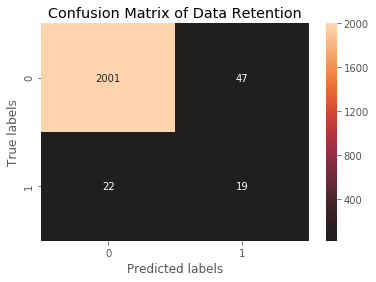

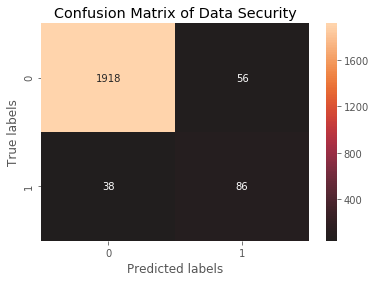

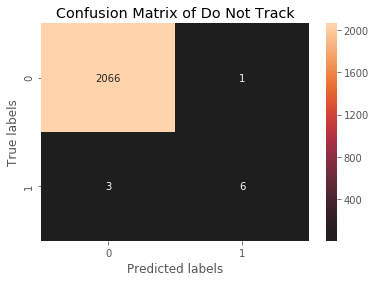

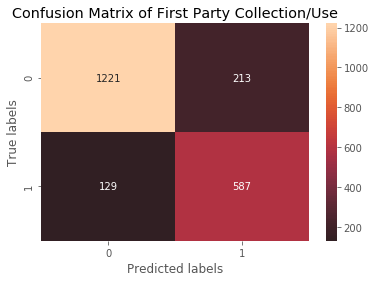

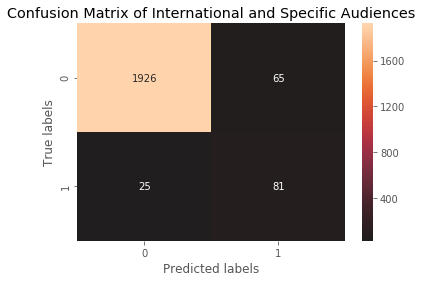

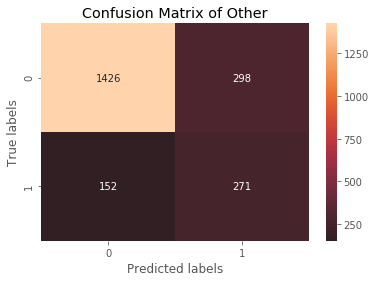

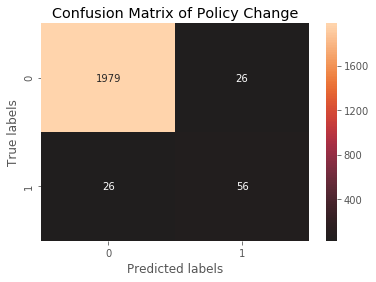

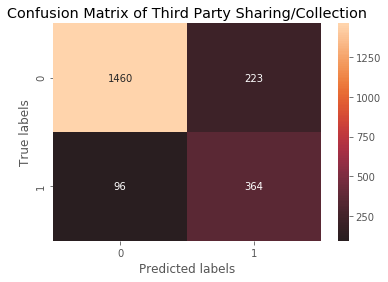

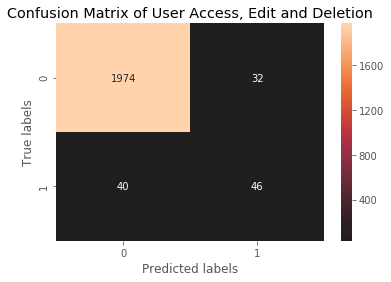

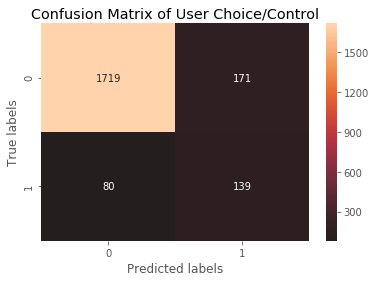

In [36]:
import seaborn as sns

def plot_confusion_matrix_seaborn(cat_confusion_matrix_dict):
    
    for key, cm in cat_confusion_matrix_dict.items():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        sns.heatmap(cm, annot=True, ax = ax, center=0, fmt="d"); #annot=True to annotate cells
        # labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix of ' + key); 
        ax.xaxis.set_ticklabels(['0', '1']); ax.yaxis.set_ticklabels(['0', '1']);
plot_confusion_matrix_seaborn(cat_confusion_matrix_dict)

In [37]:
df = pd.DataFrame(data=cat_score_dict)
df.head()

,Data Retention,Data Security,Do Not Track,First Party Collection/Use,International and Specific Audiences,Other,Policy Change,Third Party Sharing/Collection,"User Access, Edit and Deletion",User Choice/Control
accuracy,0.966970,0.955195,0.998073,0.840930,0.957082,0.790405,0.975084,0.851143,0.965583,0.880986
f1score,0.983051,0.976081,0.999033,0.877155,0.977169,0.863719,0.987032,0.901513,0.982090,0.931960
precision,0.977051,0.971631,0.999516,0.851464,0.967353,0.827146,0.987032,0.867499,0.984048,0.909524
sensitivity,0.989125,0.980573,0.998550,0.904444,0.987186,0.903676,0.987032,0.938303,0.980139,0.955531
specificity,0.287879,0.605634,0.857143,0.733750,0.554795,0.476274,0.682927,0.620102,0.589744,0.448387
